In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [17]:
ar5_df = pd.read_csv("ar4.csv")
ar5_df['defects']=ar5_df['defects'].map({True:0,False:1})
print(ar5_df.info())
X = ar5_df.iloc[:,0:30]
#print(X)
True_val=ar5_df.iloc[:,30]
print(True_val)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                107 non-null    int64  
 1   total_loc                         107 non-null    int64  
 2   blank_loc                         107 non-null    int64  
 3   comment_loc                       107 non-null    int64  
 4   code_and_comment_loc              107 non-null    int64  
 5   executable_loc                    107 non-null    int64  
 6   unique_operands                   107 non-null    int64  
 7   unique_operators                  107 non-null    int64  
 8   total_operands                    107 non-null    int64  
 9   total_operators                   107 non-null    int64  
 10  halstead_vocabulary               107 non-null    int64  
 11  halstead_length                   107 non-null    int64  
 12  halstead

In [18]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(True_val)
true_labels[:107]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [19]:
label_encoder.classes_

array([0, 1], dtype=int64)

In [20]:
n_clusters = len(label_encoder.classes_)

In [21]:
preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=2, random_state=42)),
        ]
    )

In [22]:
clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n_clusters,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=42,
               ),
           ),
       ]
    )

In [23]:
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

In [24]:
pipe.fit(X)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  MinMaxScaler(copy=True,
                                               feature_range=(0, 1))),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=2, n_init=50, n_jobs=None,
                                         precomp

In [25]:
preprocessed_data = pipe["preprocessor"].transform(X)

predicted_labels = pipe["clusterer"]["kmeans"].labels_
print(silhouette_score(preprocessed_data, predicted_labels))
print(predicted_labels-true_labels)

0.6226638587041496
[ 0  0  0  0  0  0  0  0  0  0  1  0 -1  0  1  0  0  0  0  0  1  0  0  0
  1  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0
  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  0  0  1  0  0  0  0  0  0  0]


In [26]:
adjusted_rand_score(true_labels, predicted_labels)

0.38432760962610085

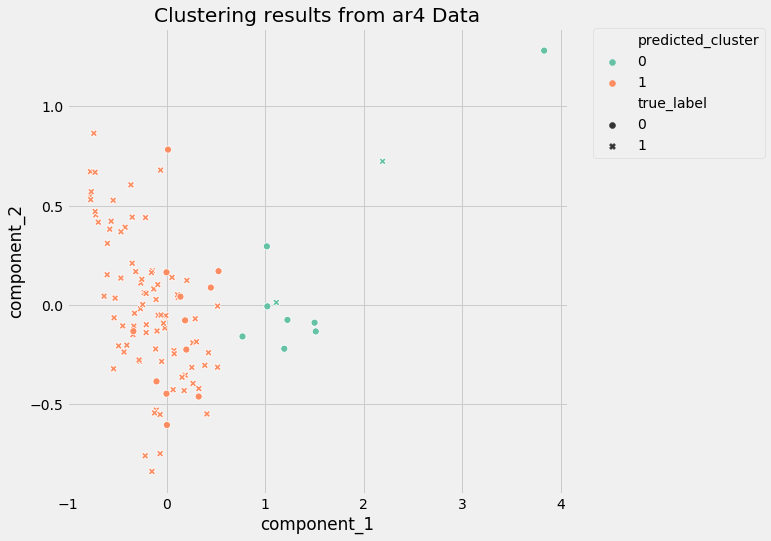

In [33]:
pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(X),
        columns=["component_1", "component_2"],
    )
 
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    "component_1",
    "component_2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="Set2",
)

scat.set_title(
    "Clustering results from ar4 Data"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [31]:
#print(true_labels)
original_clean=0
original_buggy=0
j=0
while j < len(true_labels):
    #print(true_labels[:j])
    if true_labels[j].size > 0:
        if true_labels[j]==0:
            original_buggy+=1
    j+=1
original_clean = len(true_labels) - original_buggy
print('original_clean ', original_clean)
print('original_buggy ', original_buggy)

original_clean  87
original_buggy  20


In [32]:
#print(predicted_labels)
predicted_clean=0
predicted_buggy=0
j=0
while j < len(predicted_labels):
    #print(predicted_labels[:j])
    if predicted_labels[j].size > 0:
        if predicted_labels[j]==0:
            predicted_buggy+=1
    j+=1
predicted_clean = len(predicted_labels) - predicted_buggy
print('predicted_clean ', predicted_clean)
print('predicted_buggy ', predicted_buggy)

predicted_clean  97
predicted_buggy  10


In [30]:
result=predicted_labels-true_labels
count=0
i=0
while i < len(result):
    if result[i]==0:
        count+=1
    i+=1
print('Accuracy ',count/len(result))


i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==-1:
        count+=1
    i+=1
print('FN ',count)  

i=0
count=0
while i <len(result):
    #print(result[i])
    if result[i]==1:
        count+=1
    i+=1
print('FP',count) 

i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==0 & true_labels[i]==0:
        count+=1
    i+=1
print('TP ',count) 
i=0
count=0
while i <len(result):
    #print(result[i])
    if predicted_labels[i]==1 & true_labels[i]==1:
        count+=1
    i+=1
print('TN ',count)  

Accuracy  0.8691588785046729
FN  2
FP 12
TP  10
TN  85
